In [1]:
print("Hello, World")

Hello, World


In [2]:
!pip install ollama

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [7]:
!pip install ollama

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [8]:
import ollama

In [9]:
from PIL import Image
from io import BytesIO
import base64
import os

In [10]:
# Question 1

def run_prompt_on_image(
    image_path: str,
    prompt: str,
    model: str = "ministral-3:3b"
) -> str:
    """
    Runs a text prompt on an image using a vision-capable Ollama model.

    Args:
        image_path (str): Path to the image file.
        prompt (str): User prompt describing what to do with the image.
        model (str): Ollama vision model (default: llava).

    Returns:
        str: Model-generated text response.
    """

    # --- Validate inputs ---
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")

    if not prompt.strip():
        raise ValueError("Prompt must not be empty")

    # --- Load and encode image ---
    with Image.open(image_path).convert("RGB") as img:
        buffer = BytesIO()
        img.save(buffer, format="PNG")
        image_b64 = base64.b64encode(buffer.getvalue()).decode("utf-8")

    # --- Run Ollama chat ---
    response = ollama.chat(
        model=model,
        messages=[
            {
                "role": "user",
                "content": prompt,
                "images": [image_b64],
            }
        ],
    )

    # --- Extract and return text ---
    return response["message"]["content"]

In [11]:
result = run_prompt_on_image("frame_0008.jpg", "Describe the image in detail.")
print(result)

The image captures a moment in the life of a brown bear, standing majestically on a rocky outcropping. The bear, with its rich brown fur, is facing to the right, its gaze directed towards the left side of the frame. Its body is oriented towards the right, creating a sense of balance in the composition.

The bear is positioned on the right side of the image, its body partially obscured by the rocky outcropping it stands on. This positioning adds depth to the image, drawing the viewer's eye from the foreground with the bear, to the middle ground with the rocky outcropping, and finally to the background with the lush green forest.

The background is a vibrant display of nature, filled with trees and foliage in various shades of green. The colors contrast beautifully with the bear's brown fur, making it stand out in the image. The overall scene is a harmonious blend of wildlife and nature.


In [12]:
# Question 2: Make another function that computes embedding of a string using “embeddinggemma” model, and returns a Numpy array
!pip install numpy -q
import numpy as np

def get_embedding(text, model="embeddinggemma"):
    """
    Compute the embedding of a string using the specified Ollama model.
    Returns a NumPy array.
    """
    response = ollama.embeddings(model=model, prompt=text)
    # The response should contain an 'embedding' key with a list of floats
    embedding = response.get("embedding")
    if embedding is None:
        raise ValueError("No embedding found in Ollama response.")
    return np.array(embedding)


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [13]:
#Question 3: Make our “model”: a Pandas dataframe with columns “filename”, “description”,“embedding” (a Numpy array)

!pip install pandas
import pandas as pd

data = [
    {
        "filename": "frame_0008.jpg",
        "description": "A sample image description.",
        "embedding": get_embedding("A sample image description.")
    }, ]

model_df = pd.DataFrame(data, columns=["filename", "description", "embedding"])

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [17]:
model_df

,filename,description,embedding
0,frame_0008.jpg,A sample image description.,"[-0.1472645103931427, 0.007136382162570953, -0..."


In [14]:
# 4 Make a function that take Pandas dataframe “model”, a new Embedding vector, and returns filename+description for the most similar “model” vector
import numpy as np
import pandas as pd

def find_most_similar_vectorized(model_df, new_embedding):
    """
    Vectorized version to find the most similar embedding in a DataFrame.
    Returns filename and description.
    
    model_df: DataFrame with 'embedding' column (lists or np.arrays)
    new_embedding: list or np.array
    """
    # Convert embeddings to a 2D NumPy array
    embeddings = np.stack(model_df['embedding'].values)  # shape: (n_rows, embedding_dim)
    new_embedding = np.array(new_embedding)
    
    # Normalize embeddings
    embeddings_norm = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    new_embedding_norm = new_embedding / np.linalg.norm(new_embedding)
    
    # Compute cosine similarities in one line
    similarities = embeddings_norm @ new_embedding_norm  # dot product for cosine similarity
    
    # Find the index of the most similar
    idx = np.argmax(similarities)
    row = model_df.iloc[idx]
    
    return row['filename'], row['description']

# Example usage
filename, description = find_most_similar_vectorized(model_df, get_embedding("A new description"))
print(filename, description)


frame_0008.jpg A sample image description.


In [15]:
#5 Make functions for saving and loading Pandas “model” as CSV file

def save_model_csv(model_df, filename):
    # Convert embedding arrays to strings for CSV
    df = model_df.copy()
    df['embedding'] = df['embedding'].apply(lambda arr: ','.join(map(str, arr.tolist())))
    df.to_csv(filename, index=False)

def load_model_csv(filename):
    df = pd.read_csv(filename)
    # Convert embedding strings back to numpy arrays
    df['embedding'] = df['embedding'].apply(lambda s: np.fromstring(s, sep=','))
    return df

save_model_csv(model_df, "model.csv")
loaded_df = load_model_csv("model.csv")

In [21]:
# 7. Combine together: take 3 pictures of different animals, compute their descriptions and embeddings, add to the “model” and save modelto disk.
def run_prompt_on_image(image_path, prompt, model="ministral-3:3b"):
    img = Image.open(image_path).convert("RGB")
    buf = BytesIO()
    img.save(buf, format="PNG")
    b64 = base64.b64encode(buf.getvalue()).decode("utf-8")

    image_md = f"![image](data:image/png;base64,{b64})"
    full_prompt = image_md + "\n\n" + prompt

    response = ollama.chat(
        model=model,
        messages=[{"role": "user", "content": full_prompt}]
    )

    return response["message"]["content"]

animal_images = ["frame_0008.jpg", "frame_0026.jpg", "frame_0144.jpg"]

data = []
for img in animal_images:
    # Vision step
    raw_desc = run_prompt_on_image(
        img,
        "Describe the animal in this image.",
        model="llava"
    )

    # Text-only refinement (ministral)
    clean_desc = ollama.chat(
        model="ministral-3:3b",
        messages=[{
            "role": "user",
            "content": f"Rewrite this as a concise animal description:\n{raw_desc}"
        }]
    )["message"]["content"]

    embedding = get_embedding(clean_desc)

    data.append({
        "filename": img,
        "description": clean_desc,
        "embedding": embedding
    })

model_df = pd.DataFrame(data)
save_model_csv(model_df, "model1.csv")


In [22]:
print(model_df)

         filename                                        description  \
0  frame_0008.jpg  **Description:**\nA **domestic cow** (*Bos tau...   
1  frame_0026.jpg  This is a stylized cow illustration with:\n- *...   
2  frame_0144.jpg  This is an African zebra with bold black-and-w...   

                                           embedding  
0  [-0.0218508243560791, -0.006807518657296896, -...  
1  [-0.04345850273966789, -0.014407834969460964, ...  
2  [-0.10183903574943542, 0.036318324506282806, 0...  


         filename                                        description
0  frame_0008.jpg  **Description:**\nA **domestic cow** (*Bos tau...
1  frame_0026.jpg  This is a stylized cow illustration with:\n- *...
2  frame_0144.jpg  This is an African zebra with bold black-and-w...
Most similar image:
Filename: frame_0026.jpg
Description: This is a stylized cow illustration with:
- **Horns, ears, and tail** in a cartoonish design
- **Fur-like furrows** in muted browns, blacks, and whites
- **Four legs** standing still, facing right
- **No text or context details** visible.


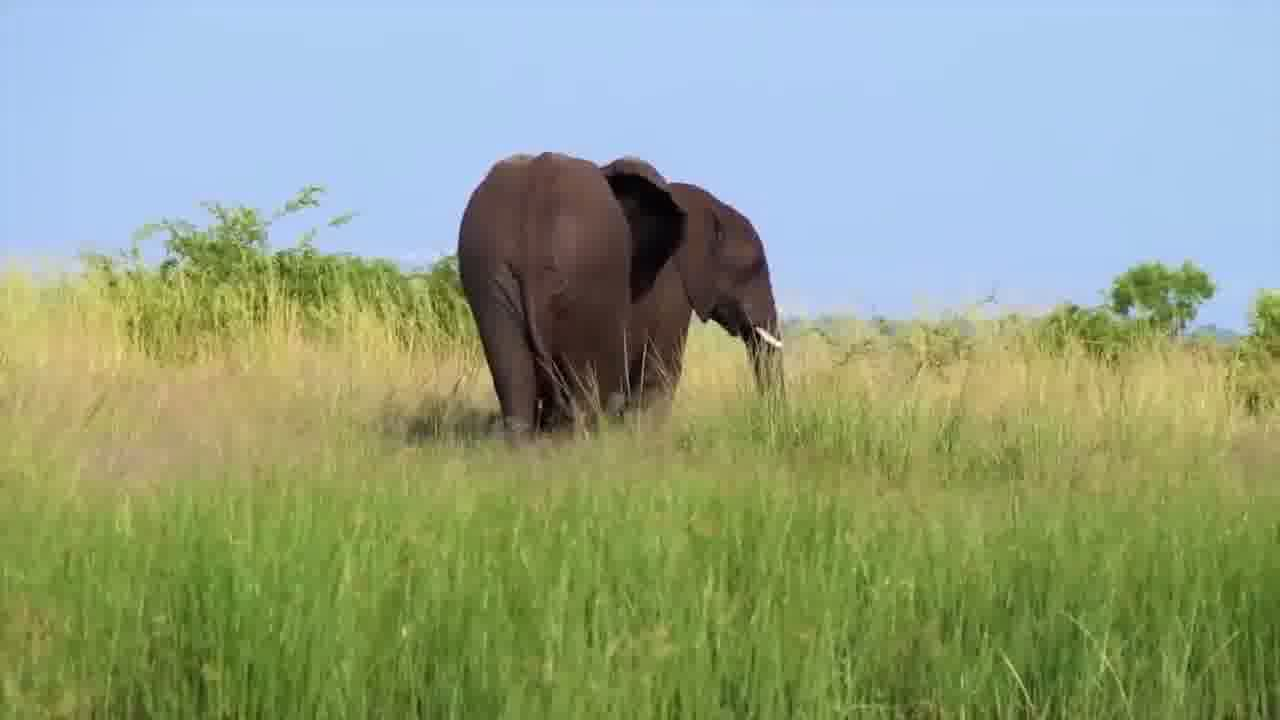

In [23]:
#Question 8 Test: make a query like “Show me a bear”, compute its embedding, then returnfilename and description of the most similar image. You can show the image too in Jupyter notebook.

import pandas as pd
import numpy as np

loaded_df = load_model_csv("model1.csv")
print(loaded_df[["filename", "description"]])

query = "Show me a bear"
query_embedding = get_embedding(query)

filename, description = find_most_similar_vectorized(
    loaded_df,
    query_embedding
)

print("Most similar image:")
print("Filename:", filename)
print("Description:", description)

from IPython.display import Image, display

display(Image(filename=filename))


In [ ]:
'''
Question 10: Serving frontend: make a frontend that loads the “model”, takes request,
computes its embeddings, and returns image file name + description.
'''